In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime, time

In [ ]:
random.seed(1038472)
# Need to fix the random selector in order to ensure that we are randomly selecting rows for the file
n = 55000000 + 423844
s = 300000
skip = sorted(random.sample(range(1,n),n-s))
train = pd.read_csv('train.csv', skiprows = skip)

In [ ]:
# DATA CLEANING
train = train.drop(train[pd.isnull(train['dropoff_longitude'])].index, axis = 0)
train = train.drop(train[train['fare_amount'] <= 2.5].index, axis=0)
train = train.drop(train[(train['passenger_count'] == 208)|(train['passenger_count'] == 0)].index, axis = 0)
train = train.drop(train[(train['pickup_latitude'] < 40.5)|(train['pickup_latitude'] > 41.8)].index, axis=0)
train = train.drop(train[(train['dropoff_latitude'] < 40.5)|(train['dropoff_latitude'] > 41.8)].index, axis=0)
train = train.drop(train[(train['pickup_longitude'] < -74.5)|(train['pickup_longitude'] > -72.8)].index, axis=0)
train = train.drop(train[(train['dropoff_longitude'] < -74.5)|(train['dropoff_longitude'] > -72.8)].index, axis=0)
train = train.drop(train[train['passenger_count'] > 6].index, axis = 0)

In [ ]:
# Change the datetime strings to datetime objects
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [ ]:
# Adding new features about the pick up / drop off times (separating datetime into its individual components)
# These are the ones that we consider important to training our model
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['hour_of_day'] = train['pickup_datetime'].dt.hour
train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train = train.drop(['pickup_datetime'], axis = 1)
train.head()

In [ ]:
# Adding new features to allow for our model to use information about Airport trips
JFK_lon = -73.7822222222 
JFK_lat = 40.6441666667

def distance(lat1, lon1, lat2, lon2):
        R = 3959 # radius of Earth in miles
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
    
        delta_phi = np.radians(lat2-lat1)
        delta_lambda = np.radians(lon2-lon1)
    
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        return(R * c)
    
train['pickup_to_JFK_dist'] = distance(JFK_lat, JFK_lon, train['pickup_latitude'], train['pickup_longitude'])
train['dropoff_to_JFK_dist'] = distance(JFK_lat, JFK_lon, train['dropoff_latitude'], train['dropoff_longitude'])

Newark_lon = -74.1745
Newark_lat = 40.6895

train['pickup_to_Newark_dist'] = distance(Newark_lat, Newark_lon, train['pickup_latitude'], train['pickup_longitude'])
train['dropoff_to_Newark_dist'] = distance(Newark_lat, Newark_lon, train['dropoff_latitude'], train['dropoff_longitude'])

center_lon = -74.0060
center_lat = 40.7128
train['pickup_to_center_dist'] = distance(center_lat, center_lon, train['pickup_latitude'], train['pickup_longitude'])
train['dropoff_to_center_dist'] = distance(center_lat, center_lon, train['dropoff_latitude'], train['dropoff_longitude'])

# Creating a feature that indicates if a trip is to/from JFK Airport and Manhattan (the center of NY is in Manhattan)
train['JFK_Man'] = np.where(((train['pickup_to_JFK_dist']< 2) & (train['dropoff_to_center_dist'] < 5)) | 
                            ((train['dropoff_to_JFK_dist']< 2) & (train['pickup_to_center_dist'] < 5)), 1, 0)

# Creating a feature that indicates if a JFK/Manhattan trip is during rush hour for the surcharge
train['rush_hr_JFK'] = np.where((train['JFK_Man'] == True) & ((train['hour_of_day'] >= 16) & (train['hour_of_day'] <= 20)), 1, 0)

# Creating a feature that indicates if a trip is to Newark Airport
train['to_Newark'] = np.where((train['pickup_to_center_dist'] < 5) & (train['dropoff_to_Newark_dist'] < 2), 1, 0)

In [11]:
def distance(lat1, lon1, lat2, lon2):
        R = 3959 # radius of Earth in miles
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
    
        delta_phi = np.radians(lat2-lat1)
        delta_lambda = np.radians(lon2-lon1)
    
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        return(R * c)

In [ ]:
len(train[train['to_Newark'] == 1])

In [ ]:
train['trip_distance'] = distance(train.pickup_latitude, train.pickup_longitude, 
                                      train.dropoff_latitude, train.dropoff_longitude)
train = train.drop(train[train['trip_distance'] == 0].index, axis = 0)

In [ ]:
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

def plot_on_map(df, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((-74.1, -73.7))
    axs[0].set_ylim((40.6, 40.85))
    axs[0].set_title('Taxi Pickup Locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=(-74.1, -73.7, 40.6, 40.85))
    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((-74.1, -73.7))
    axs[1].set_ylim((40.6, 40.85))
    axs[1].set_title('Taxi Dropoff Locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=(-74.1, -73.7, 40.6, 40.85))
    
                  
plot_on_map(train, nyc_map_zoom, s = 0.05, alpha = 0.05)

In [ ]:
train = train.drop(['passenger_count', 'month', 'day_of_week'], axis = 1)
print(train.corrwith(train['fare_amount']))

In [4]:
def rotate_coordinates(df):
    rot = np.deg2rad(29)
    df['pickup_rot_long'] = df.pickup_longitude * np.cos(rot) - df.pickup_latitude * np.sin(rot)
    df['pickup_rot_lat'] = df.pickup_longitude * np.sin(rot) + df.pickup_latitude * np.cos(rot)
    df['dropoff_rot_long'] = df.dropoff_longitude * np.cos(rot) - df.dropoff_latitude * np.sin(rot)
    df['dropoff_rot_lat'] = df.dropoff_longitude * np.sin(rot) + df.dropoff_latitude * np.cos(rot)
    df = df.drop(['pickup_longitude','pickup_latitude', 'dropoff_latitude', 'dropoff_longitude'], axis = 1)
    return df

In [2]:
train = pd.read_csv('/Users/SimsMat/Desktop/STATS415/TaxiFareProject/TaxiData.csv', )

In [5]:
train_trans = train.copy(deep=True)
train_trans = rotate_coordinates(train_trans)

# Creating data frame with haversine distance and original longitude and latitude
train_haversine = train.copy(deep=True)

# Creating data frame with haversine distance and rotated longitude and latitude
train_haversine_rot = train_trans.copy(deep=True)

In [6]:
from sklearn.model_selection import train_test_split
random.seed(1038472)
# Creating training and testing set for data with haversine and original long. and lat.
train_h, test_h = train_test_split(train_haversine, test_size=0.2)
y_train_h = train_h['fare_amount']
x_train_h = train_h.drop(['key', 'fare_amount'], axis = 1)
y_test_h = test_h['fare_amount']
x_test_h = test_h.drop(['key', 'fare_amount'], axis = 1)

# Creating training and testing set for data with haversine and rotated long. and lat.
train_h_rot, test_h_rot = train_test_split(train_haversine_rot, test_size=0.2)
y_train_h_rot = train_h_rot['fare_amount']
x_train_h_rot = train_h_rot.drop(['key', 'fare_amount'], axis = 1)
y_test_h_rot = test_h_rot['fare_amount']
x_test_h_rot = test_h_rot.drop(['key', 'fare_amount'], axis = 1)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr = LinearRegression()
lr.fit(x_train_h, y_train_h)
predict_regression = lr.predict(x_test_h)
rmse_regression = np.sqrt(metrics.mean_squared_error(predict_regression, y_test_h))
print(rmse_regression)

4.417129106151541


In [ ]:
# Determining the max_depth to use when training the Random Forest
from sklearn.ensemble import RandomForestRegressor
max_depths = np.linspace(1, 32, 32, endpoint=True)
test_results = []
    
for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train_h, y_train_h)
    predict_test = rf.predict(x_test_h)
    rmse_test = np.sqrt(metrics.mean_squared_error(predict_test, y_test_h))
    test_results_.append(rmse_test)

In [ ]:
# Plotting the RMSE against the depth level
plt.plot(max_depths, test_results, 'b')
plt.title("The Effect of Depth on Validation RMSE")
plt.ylabel("Validation RMSE")
plt.xlabel("Max Depth Of Trees")

In [ ]:
max_depths[np.argmin(test_results)]

In [ ]:
# Determining the number of trees to use when training the Random Forest
from sklearn.ensemble import RandomForestRegressor
num_trees = [1, 2, 4, 8, 16, 32, 64, 100, 200]
test_results_sqrt = []
test_results_half = []
test_results_p = []
    
for num_tree in num_trees:
    rf = RandomForestRegressor(n_estimators = num_tree, max_depth=13, max_features = 4, n_jobs=-1)
    rf.fit(x_train_h, y_train_h)
    predict_test_h = rf.predict(x_test_h)
    rmse_test = np.sqrt(metrics.mean_squared_error(predict_test_h, y_test_h))
    test_results_sqrt.append(rmse_test)
    
for num_tree in num_trees:
    rf = RandomForestRegressor(n_estimators = num_tree, max_depth=13, max_features = 8, n_jobs=-1)
    rf.fit(x_train_h, y_train_h)
    predict_test_h = rf.predict(x_test_h)
    rmse_test = np.sqrt(metrics.mean_squared_error(predict_test_h, y_test_h))
    test_results_half.append(rmse_test)
    
for num_tree in num_trees:
    rf = RandomForestRegressor(n_estimators = num_tree, max_depth=13, n_jobs=-1)
    rf.fit(x_train_h, y_train_h)
    predict_test_h = rf.predict(x_test_h)
    rmse_test = np.sqrt(metrics.mean_squared_error(predict_test_h, y_test_h))
    test_results_p.append(rmse_test)

In [32]:
# Determining the minimum number of samples for a split
num_samples = [2, 10, 50, 75, 100, 200]
samp_result = []
for samp in num_samples:
    rf = RandomForestRegressor(n_estimators = 64, max_depth=13, max_features = 8, 
                               min_samples_split = samp ,n_jobs=-1)
    rf.fit(x_train_h, y_train_h)
    predict_test_h = rf.predict(x_test_h)
    rmse_test = np.sqrt(metrics.mean_squared_error(predict_test_h, y_test_h))
    samp_result.append(rmse_test)

[3.4039857610243316,
 3.4099592113350057,
 3.4336055920282518,
 3.429803161914939,
 3.4431944785073743,
 3.4927585136882016]

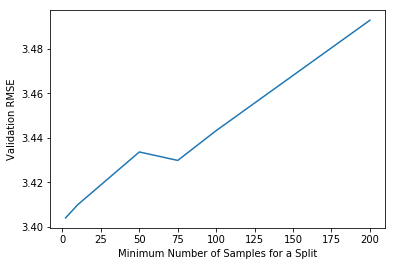

In [35]:
plt.plot(num_samples, samp_result)
plt.xlabel("Minimum Number of Samples for a Split")
plt.ylabel("Validation RMSE")

In [ ]:
import matplotlib.patches as mpatches
plt.plot(num_trees, test_results_p, color = "green")
plt.plot(num_trees, test_results_half, color = "blue")
plt.plot(num_trees, test_results_sqrt, color = "red")
green_patch = mpatches.Patch(color='green', label= 'm = p')
blue_patch = mpatches.Patch(color='blue', label=r'm = $\frac{p}{2}$')
red_patch = mpatches.Patch(color='red', label=r'm = $\sqrt{p}$')
plt.legend(handles = [green_patch, blue_patch, red_patch])
plt.title("The Effect Maximum Number of Features on Validation RMSE")
plt.ylabel("Validation RMSE")
plt.xlabel("Number Of Trees")
plt.show()

In [8]:
# Training the Random Forest using a max_depth of 13 / Original Latitude and Longitude / Haversine Distance
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 64, max_depth=13, max_features = 8, n_jobs=-1)
rf.fit(x_train_h, y_train_h)
predict_test_h = rf.predict(x_test_h)
rmse_test = np.sqrt(metrics.mean_squared_error(predict_test_h, y_test_h))
print(rmse_test)

3.4055517259727544


In [9]:
# Training the Random Forest using a max_depth of 13 / Rotated Latitude and Longitude / Haversine Distance
from sklearn.ensemble import RandomForestRegressor
rf_rot = RandomForestRegressor(n_estimators = 64, max_depth=13, max_features = 8, n_jobs=-1)
rf_rot.fit(x_train_h_rot, y_train_h_rot)
predict_test_h_rot = rf_rot.predict(x_test_h_rot)
rmse_rf_h_rot = np.sqrt(metrics.mean_squared_error(predict_test_h_rot, y_test_h_rot))
print(rmse_rf_h_rot)

3.480415672799264


In [12]:
# Adding the Manhattan distance into data set and removing the Haversine distance
def manhattan_dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return distance(pickup_lat, pickup_long, pickup_lat, dropoff_long) + distance(pickup_lat, dropoff_long, dropoff_lat, dropoff_long)

train_manhattan_rot = train_haversine.copy(deep = True)

train_manhattan_rot['trip_distance'] = manhattan_dist(train.pickup_latitude, train.pickup_longitude, 
                                      train.dropoff_latitude, train.dropoff_longitude)

train_manhattan = train_manhattan_rot.copy(deep = True)

In [13]:
# Creating two sets of training and testing sets (Manhattan - Original Coordinates and Manhattan - Rotated Coordinates)
from sklearn.model_selection import train_test_split
random.seed(1038472)
train_m_rot, test_m_rot = train_test_split(train_manhattan_rot, test_size=0.2)
y_train_m_rot = train_m_rot['fare_amount']
x_train_m_rot = train_m_rot.drop(['key', 'fare_amount'], axis = 1)
y_test_m_rot = test_m_rot['fare_amount']
x_test_m_rot = test_m_rot.drop(['key', 'fare_amount'], axis = 1)

train_m, test_m = train_test_split(train_manhattan, test_size=0.2)
y_train_m = train_m['fare_amount']
x_train_m = train_m.drop(['key', 'fare_amount'], axis = 1)
y_test_m = test_m['fare_amount']
x_test_m = test_m.drop(['key', 'fare_amount'], axis = 1)

In [14]:
# Training the Random Forest using a max_depth of 15 / Original Latitude and Longitude / Manhattan Distance
from sklearn.ensemble import RandomForestRegressor
rf_m = RandomForestRegressor(n_estimators = 64, max_depth = 13, max_features = 8, n_jobs = -1)
rf_m.fit(x_train_m, y_train_m)
predict_m = rf_m.predict(x_test_m)
rmse_m = np.sqrt(metrics.mean_squared_error(predict_m, y_test_m))
print(rmse_m)

3.5818021893056233


In [15]:
# Training the Random Forest using a max_depth of 15 / Rotated Latitude and Longitude / Manhattan Distance
from sklearn.ensemble import RandomForestRegressor
rf_m_rot = RandomForestRegressor(n_estimators= 64, max_depth = 13, max_features = 8, n_jobs = -1)
rf_m_rot.fit(x_train_m_rot, y_train_m_rot)
predict_m_rot = rf_m_rot.predict(x_test_m_rot)
rmse_m_rot = np.sqrt(metrics.mean_squared_error(predict_m_rot, y_test_m_rot))
print(rmse_m_rot)

3.5899081038255405


In [21]:
from xgboost import XGBRegressor
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.175, 0.2, 0.25, 0.275, 0.3]
rate_results = []
for rate in learning_rate:
    rf_boost = XGBRegressor(n_estimators= 64, learning_rate = rate, max_depth = 13, n_jobs = -1)
    rf_boost.fit(x_train_h, y_train_h)
    predict_boost = rf_boost.predict(x_test_h)
    rmse_boost = np.sqrt(metrics.mean_squared_error(predict_boost, y_test_h))
    rate_results.append(rmse_boost)
    

Text(0,0.5,'Validation RMSE')

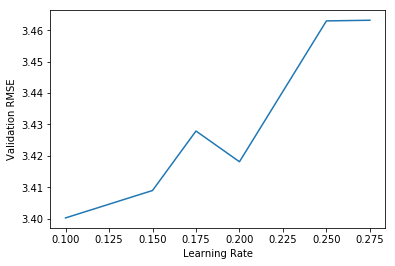

In [28]:
plt.plot(learning_rate[3:9], rate_results[3:9])
plt.xlabel("Learning Rate")
plt.ylabel("Validation RMSE")

In [23]:
print(rate_results)

[14.400009241015638, 13.649868444073746, 8.231753738520245, 3.40026661577118, 3.4089880346296217, 3.4279198431532816, 3.418141837295859, 3.462958263777891, 3.4631680214700213, 3.490255864418407]


In [29]:
rf_boost = XGBRegressor(n_estimators= 64, learning_rate = 0.1, max_depth = 13, n_jobs = -1)
rf_boost.fit(x_train_h, y_train_h)
predict_boost = rf_boost.predict(x_test_h)
rmse_boost = np.sqrt(metrics.mean_squared_error(predict_boost, y_test_h))
rate_results.append(rmse_boost)
print(rmse_boost)

3.40026661577118
